### *IPCC SR15 scenario assessment*

<img style="float: right; height: 120px; margin-top: 10px;" src="../_static/IIASA_logo.png">
<img style="float: right; height: 100px;" src="../_static/IAMC_logo.jpg">

# Scenario categorization and indicators

This notebook assigns the categorization by warming outcome and computes a range of descriptive indicators
for the scenario assessment of the IPCC's _"Special Report on Global Warming of 1.5°C"_.
It generates a `sr15_metadata_indicators.xlsx` spreadsheet, which is used in other notebooks for this assessment
for categorization and extracting descriptive indicators.

## Scenario ensemble data

The scenario data used in this analysis can be accessed and downloaded at [https://data.ene.iiasa.ac.at/iamc-1.5c-explorer](https://data.ene.iiasa.ac.at/iamc-1.5c-explorer).

Bibliographic details of the scenario ensemble and all studies that contributed scenarios to the ensemble
are included in this repository
as [Endnote (enl)](../bibliography/iamc_1.5c_scenario_data.enl),
[Reference Manager (ris)](../bibliography/iamc_1.5c_scenario_data.ris),
and [BibTex (bib)](../bibliography/iamc_1.5c_scenario_data.bib) format.

## License and recommended citation

This notebook is licensed under the Apache License, Version 2.0.

Please refer to the [README](../README.md) for the recommended citation of the scenario ensemble and the notebooks in this repository.

***

## Import dependencies and define general notebook settings

In [4]:
import math
import io
import yaml
import re
import pandas as pd
import numpy as np
from IPython.display import display

### Introduction and tutorial for the `pyam` package

This notebook (and all other analysis notebooks in this repository) uses the `pyam` package,
an open-source Python package for IAM scenario analysis and visualization
([pyam-iamc.readthedocs.io](https://pyam-iamc.readthedocs.io)).

For an introduction of the notation and features of the `pyam` package,
please refer to [this tutorial](https://github.com/IAMconsortium/pyam/blob/master/doc/source/tutorials/pyam_first_steps.ipynb).  
It will take you through the basic functions and options used here,
and provide further introduction and guidelines.

In [5]:
import pyam
logger = pyam.logger

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


### Import Matplotlib and set figure layout defaults in line with SR1.5 guidelines

In [6]:
import matplotlib.pyplot as plt
plt.style.use('style_sr15.mplstyle')

## Import scenario snapshot and define auxiliary dictionaries

This notebook only assigns indicator based on global timeseries data.

The dictionary `meta_tables` is used to collect definitions
of categories and secondary scenario classification throughout this script.
These definitions are exported to the metadata/categorization Excel workbook
at the end of the script for completeness.
The dictionary `meta_docs` collects definitions used for the documentation tags
in the online scenario explorer.

The dictionary `specs` collects lists and the run control specifications to be exported to JSON
and used by other notebooks for the SR1.5 scenario analysis.

The `plotting_args` dictionary assigns the default plotting arguemnts in this notebook.

In [7]:
sr1p5 = pyam.IamDataFrame(data='../data/iamc15_scenario_data_world_r2.0.xlsx')

pyam.utils - INFO: Reading `../data/iamc15_scenario_data_world_r2.0.xlsx`


In [8]:
meta_tables = {}
meta_docs = {}

In [9]:
specs = {}

In [10]:
plotting_args = {'color': 'category', 'linewidth': 0.2}
specs['plotting_args'] = plotting_args

## Verify completeness of scenario submissions for key variables

Verify that every scenario except for *Shell Sky* and the historical reference scenarios reports CO2 Emissions in 2030.

In [11]:
sr1p5.require_variable(variable='Emissions|CO2', year=2030, exclude_on_fail=False)

pyam.core - INFO: 3 scenarios do not include required variable `Emissions|CO2`


,model,scenario
0,Reference,CEDS
1,Reference,IEA Energy Statistics (r2017)
2,Shell World Energy Model 2018,Sky


## Check MAGICC postprocessing prior to categorization

Assign scenarios that could not be postprocessed by probabilistic MAGICC to respective categories:  
 - data not available for full century
 - insufficient reporting of emission species
 - reference scenario

In [12]:
sr1p5.set_meta(name='category', meta= 'uncategorized')

In [13]:
reference = sr1p5.filter(model='Reference')
pd.DataFrame(index=reference.meta.index)

Empty DataFrame
Columns: []
Index: [(Reference, CEDS), (Reference, IEA Energy Statistics (r2017))]

In [14]:
sr1p5.set_meta(meta='reference', name='category', index=reference)

In [15]:
no_climate_assessment = (
    sr1p5.filter(category='uncategorized').meta.index
    .difference(sr1p5.filter(year=2100, variable='Emissions|CO2').meta.index)
)
pd.DataFrame(index=no_climate_assessment)

,
model,scenario
GENeSYS-MOD 1.0,1.0
IEA Energy Technology Perspective Model 2017,B2DS
Shell World Energy Model 2018,Sky


In [16]:
sr1p5.set_meta(meta='no-climate-assessment', name='category', index=no_climate_assessment)

## Categorization of scenarios

This section applies the categorization of scenario as defined in Chapter 2 of the Special Report
for unique assignment of scenarios.

The category specification as agreed upon at LAM 3 in Malmö is repeated here for easier reference.

The term $P_{x°C}$ refers to the probability of exceeding warming of $x°C$ throughout the century in at least one year
and $P_{x°C}(y)$ refers to the probability of exceedance in a specific year $y$.

|**Categories** |**Subcategories**|**Probability to exceed warming threshold**|**Acronym**      |**Color**       |
|---------------|-----------------|-------------------------------------------|-----------------|----------------|
| Below 1.5°C   | Below 1.5°C (I) | $P_{1.5°C} \leq 0.34$                      | Below 1.5C (I)  | xkcd:baby blue |
|               | Below 1.5°C (II)| $0.34 < P_{1.5°C} \leq 0.50$               | Below 1.5C (II) |                |
| 1.5°C return with low OS | Lower 1.5°C return with low OS | $0.50 < P_{1.5°C} \leq 0.67$ and $P_{1.5°C}(2100) \leq 0.34$ |(Lower) 1.5C low OS | xkcd:bluish |
|               | Higher 1.5°C return with low OS | $0.50 < P_{1.5°C} \leq 0.67$ and $0.34 < P_{1.5°C}(2100) \leq 0.50$ |(Higher) 1.5C low OS |             |
| 1.5°C return with high OS | Lower 1.5°C return with high OS  | $0.67 < P_{1.5°C}$ and $P_{1.5°C}(2100) \leq 0.34$ | (Lower) 1.5C high OS | xkcd:darkish blue |
|               | Higher 1.5°C return with high OS | $0.67 < P_{1.5°C}$ and $0.34 < P_{1.5°C}(2100) \leq 0.50$ | (Higher) 1.5C high OS |             |
| Lower 2.0°C   |                 | $P_{2.0°C} \leq 0.34$ (excluding above)        | Lower 2C      | xkcd:orange |
| Higher 2.0°C  |                 | $0.34 < P_{2.0°C} \leq 0.50$ (excluding above) | Higher 2C     | xkcd:red    | 
| Above 2.0°C   |                 | $P_{2.0°C} > 0.50$ for at least 1 year         | Above 2C      | darkgrey    | 

### Category definitions to Excel

The following dictionary repeats the category definitions from the table above
and saves them as a `pandas.DataFrame` to a dictionary `meta_tables`.
Throughout the notebook, this dictionary is used to collect definitions
of categories and secondary scenario classification.
These definitions are exported to the metadata/categorization Excel workbook
at the end of the script for easy reference.

In [17]:
dct = {'Categories of scenarios': 
           ['Below 1.5°C', 
            '', 
            '1.5°C return with low overshoot',
            '',
            '1.5°C return with high overshoot',
            '',
            'Lower 2.0°C',
            'Higher 2.0°C',
            'Above 2.0°C'],
        'Subcategories': 
           ['Below 1.5°C (I)', 
            'Below 1.5°C (II)', 
            'Lower 1.5°C return with low overshoot',
            'Higher 1.5°C return with low overshoot',
            'Lower 1.5°C return with high overshoot',
            'Higher 1.5°C return with high overshoot',
            '',
            '',
            ''],
       'Criteria for assignment to category':
           ['P1.5°C ≤ 0.34',
            '0.34 < P1.5°C ≤ 0.50',
            '0.50 < P1.5°C ≤ 0.67 and P1.5°C(2100) ≤ 0.34',
            '0.50 < P1.5°C ≤ 0.67 and 0.34 < P1.5°C(2100) ≤ 0.50',
            '0.67 < P1.5°C and P1.5°C(2100) ≤ 0.34',
            '0.67 < P1.5°C and 0.34 < P1.5°C(2100) ≤ 0.50',
            'P2.0°C ≤ 0.34 (excluding above)',
            '0.34 < P2.0°C ≤ 0.50 (excluding above)',
            'P2.0°C > 0.50 during at least 1 year'
           ],
       'Acronym':
           ['Below 1.5C (I)',
            'Below 1.5C (II)',
            'Lower 1.5C low overshoot',
            'Higher 1.5C low overshoot',
            'Lower 1.5C high overshoot',
            'Higher 1.5C high overshoot',
            'Lower 2C',
            'Higher 2C',
            'Above 2C'],
        'Color':
           ['xkcd:baby blue',
            '',
            'xkcd:bluish',
            '',
            'xkcd:darkish blue',
            '',
            'xkcd:orange',
            'xkcd:red',
            'darkgrey']
      }
cols = ['Categories of scenarios', 'Subcategories', 'Criteria for assignment to category', 'Acronym', 'Color']
categories_doc = pd.DataFrame(dct)[cols]
meta_tables['categories'] = categories_doc
meta_docs['category'] = 'Categorization of scenarios by global warming impact'
meta_docs['subcategory'] = 'Sub-categorization of scenarios by global warming impact'

In [18]:
other_cats = ['no-climate-assessment', 'reference']

cats = ['Below 1.5C', '1.5C low overshoot', '1.5C high overshoot', 'Lower 2C', 'Higher 2C', 'Above 2C']
all_cats = cats + other_cats

subcats = dct['Acronym']
all_subcats = subcats + other_cats

In [19]:
specs['cats'] = cats
specs['all_cats'] = all_cats

specs['subcats'] = subcats
specs['all_subcats'] = all_subcats

### Subcategory assignment

We first assign the subcategories, then aggregate those assignment to the main categories.
The categories assigned above to indicate reasons for non-processing by MAGICC are copied over to the subcategories.

Keep in mind that setting a category will re-assign scenarios (in case they have already been assigned).
So in case of going back and forth in this notebook (i.e., not executing the cells in the correct order), 
make sure to reset the categorization.

In [20]:
def warming_exccedance_prob(x):
    return 'AR5 climate diagnostics|Temperature|Exceedance Probability|{} °C|MAGICC6'.format(x)

expected_warming = 'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|Expected value'
median_warming = 'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED'

In [21]:
sr1p5.set_meta(meta=sr1p5['category'], name='subcategory')

In [22]:
pyam.categorize(sr1p5, exclude=False, subcategory='uncategorized',
                value='Below 1.5C (I)', name='subcategory',
                criteria={warming_exccedance_prob(1.5): {'up': 0.34}},
                color='xkcd:baby blue')

pyam.core - INFO: No scenarios satisfy the criteria


In [23]:
pyam.categorize(sr1p5, exclude=False, subcategory='uncategorized',
                value='Below 1.5C (II)', name='subcategory',
                criteria={warming_exccedance_prob(1.5): {'up': 0.50}},
                color='xkcd:baby blue')

pyam.core - INFO: 9 scenarios categorized as `subcategory: Below 1.5C (II)`


To categorize by a variable using multiple filters (here: less than 66% probability of exceeding 1.5°C at any point during the century and less than 34% probability of exceeding that threshold in 2100) requires to perform the assignment in three steps - first, categorize to an intermediate `low OS` category and, in a second step, assign to the category in question. The third step resets all scenarios still categorized as intermediate after the second step back to `uncategorized`.

In [24]:
pyam.categorize(sr1p5, exclude=False, subcategory='uncategorized',
                value='low overshoot', name='subcategory',
                criteria={warming_exccedance_prob(1.5): {'up': 0.67}})

pyam.core - INFO: 55 scenarios categorized as `subcategory: low overshoot`


In [25]:
pyam.categorize(sr1p5, exclude=False, subcategory='low overshoot',
                value='Lower 1.5C low overshoot', name='subcategory',
                criteria={warming_exccedance_prob(1.5): {'up': 0.34, 'year': 2100}},
                color='xkcd:bluish')

pyam.core - INFO: 34 scenarios categorized as `subcategory: Lower 1.5C low overshoot`


In [26]:
pyam.categorize(sr1p5, exclude=False, subcategory='low overshoot',
                value='Higher 1.5C low overshoot', name='subcategory',
                criteria={warming_exccedance_prob(1.5): {'up': 0.50, 'year': 2100}},
                color='xkcd:bluish')

pyam.core - INFO: 10 scenarios categorized as `subcategory: Higher 1.5C low overshoot`


Display scenarios that satisfy the `low overshoot` criterion
but are not assigned to `Lower 1.5C lower overshoot` or `Higher 1.5C lower overshoot`.
Then, reset them to uncategorized.

In [27]:
sr1p5.filter(subcategory='low overshoot').meta

exclude       category  \
model       scenario                                                 
AIM/CGE 2.0 ADVANCE_2020_WB2C                 False  uncategorized   
            SFCM_SSP2_EEEI_1p5Degree          False  uncategorized   
            SFCM_SSP2_LifeStyle_1p5Degree     False  uncategorized   
            SFCM_SSP2_Ref_1p5Degree           False  uncategorized   
            SFCM_SSP2_ST_CCS_1p5Degree        False  uncategorized   
            SFCM_SSP2_ST_bio_1p5Degree        False  uncategorized   
            SFCM_SSP2_ST_nuclear_1p5Degree    False  uncategorized   
            SFCM_SSP2_ST_solar_1p5Degree      False  uncategorized   
            SFCM_SSP2_ST_wind_1p5Degree       False  uncategorized   
            SFCM_SSP2_SupTech_1p5Degree       False  uncategorized   
            SFCM_SSP2_combined_1p5Degree      False  uncategorized   

                                              subcategory  
model       scenario                                       
AIM/CGE 2.0 ADVANCE_2020_WB2C               low overshoot  
            SFCM_SSP2_EEEI_1p5Degree        low overshoot  
            SFCM_SSP2_LifeStyle_1p5Degree   low overshoot  
            SFCM_SSP2_Ref_1p5Degree         low overshoot  
            SFCM_SSP2_ST_CCS_1p5Degree      low overshoot  
            SFCM_SSP2_ST_bio_1p5Degree      low overshoot  
            SFCM_SSP2_ST_nuclear_1p5Degree  low overshoot  
            SFCM_SSP2_ST_solar_1p5Degree    low overshoot  
            SFCM_SSP2_ST_wind_1p5Degree     low overshoot  
            SFCM_SSP2_SupTech_1p5Degree     low overshoot  
            SFCM_SSP2_combined_1p5Degree    low overshoot

In [28]:
sr1p5.set_meta(meta='uncategorized', name='subcategory', index=sr1p5.filter(subcategory='low overshoot'))

Determine all scenarios with a probability to exceed 1.5°C greater than 66% in any year throughout the century.
The function `categorize()` cannot be used for this selection, because it would either check for the criteria being true for all years or for a particular year.

In [29]:
df = sr1p5.filter(exclude=False, subcategory='uncategorized', variable=warming_exccedance_prob(1.5)).timeseries()
sr1p5.set_meta(meta='high overshoot', name='subcategory', 
               index=df[df.apply(lambda x: max(x), axis=1) > 0.66].index)

In [30]:
pyam.categorize(sr1p5, exclude=False, subcategory='high overshoot',
                value='Lower 1.5C high overshoot', name='subcategory',
                criteria={warming_exccedance_prob(1.5): {'up': 0.34, 'year': 2100}},
                color='xkcd:darkish blue')

pyam.core - INFO: 19 scenarios categorized as `subcategory: Lower 1.5C high overshoot`


In [31]:
pyam.categorize(sr1p5, exclude=False, subcategory='high overshoot',
                value='Higher 1.5C high overshoot', name='subcategory',
                criteria={warming_exccedance_prob(1.5): {'up': 0.50, 'year': 2100}},
                color='xkcd:darkish blue')

pyam.core - INFO: 18 scenarios categorized as `subcategory: Higher 1.5C high overshoot`


Reset scenarios that satisfy the `high overshoot` criterion
but are not assigned to `Lower 1.5C high overshoot` or `Higher 1.5C high overshoot`.

In [32]:
sr1p5.set_meta(meta='uncategorized', name='subcategory', index=sr1p5.filter(subcategory='high overshoot'))

In [33]:
pyam.categorize(sr1p5, exclude=False, subcategory='uncategorized',
                value='Lower 2C', name='subcategory',
                criteria={warming_exccedance_prob(2.0): {'up': 0.34}},
                color='xkcd:orange')

pyam.core - INFO: 74 scenarios categorized as `subcategory: Lower 2C`


In [34]:
pyam.categorize(sr1p5, exclude=False, subcategory='uncategorized',
                value='Higher 2C', name='subcategory',
                criteria={warming_exccedance_prob(2.0): {'up': 0.50}},
                color='xkcd:red')

pyam.core - INFO: 58 scenarios categorized as `subcategory: Higher 2C`


In [35]:
pyam.categorize(sr1p5, exclude=False, subcategory='uncategorized',
                value='Above 2C', name='subcategory',
                criteria={warming_exccedance_prob(2.0): {'up': 1.0}},
                color='darkgrey')

pyam.core - INFO: 189 scenarios categorized as `subcategory: Above 2C`


### Aggregation of subcategories to categories

In [36]:
rc = pyam.run_control()
def assign_rc_color_from_sub(cat, sub):
    rc.update({'color': {'category': {cat: rc['color']['subcategory'][sub]}}})

In [37]:
sr1p5.set_meta(meta='Below 1.5C', name='category',
               index=sr1p5.filter(subcategory=['Below 1.5C (I)', 'Below 1.5C (II)']).meta.index)
assign_rc_color_from_sub('Below 1.5C', 'Below 1.5C (II)')

In [38]:
sr1p5.set_meta(meta='1.5C low overshoot', name='category',
               index=sr1p5.filter(subcategory=['Lower 1.5C low overshoot', 'Higher 1.5C low overshoot']))
assign_rc_color_from_sub('1.5C low overshoot', 'Lower 1.5C low overshoot')

In [39]:
sr1p5.set_meta(meta='1.5C high overshoot', name='category',
               index=sr1p5.filter(subcategory=['Lower 1.5C high overshoot', 'Higher 1.5C high overshoot']))
assign_rc_color_from_sub('1.5C high overshoot', 'Lower 1.5C high overshoot')

In [40]:
cats_non15 = ['Lower 2C', 'Higher 2C', 'Above 2C']
df_2c = sr1p5.filter(subcategory=cats_non15)
sr1p5.set_meta(meta=df_2c['subcategory'], name='category')

for c in cats_non15:
    assign_rc_color_from_sub(c, c)

### Additional assessment of categorization

Check whether there are any scenarios that return to 1.5°C by the end of the century and exceed the 2°C threshold with a likelyhood higher than 34% or 50% (i.e., the `Lower 2C` or the `Higher 2C` categories respectively). Having scenario categorized as `1.5C` but with a higher-than-50% probability of exceeding 2°C at some point in the century may need to be considered separately in subsequent assessment.

In [41]:
cats_15 = ['Below 1.5C', '1.5C low overshoot', '1.5C high overshoot']
specs['cats_15'] = cats_15

In [42]:
cats_15_no_lo = ['Below 1.5C', '1.5C low overshoot']
specs['cats_15_no_lo'] = cats_15_no_lo

In [43]:
cats_2 = ['Lower 2C', 'Higher 2C']
specs['cats_2'] = cats_2

In [44]:
df = sr1p5.filter(exclude=False, category=cats_15, variable=warming_exccedance_prob(2.0)).timeseries()
ex_prob_2 = df.apply(lambda x: max(x))

In [45]:
if max(ex_prob_2) > 0.34:
    logger.warning('The following 1.5C-scenarios are not `Lower 2C` scenarios:')
    display(df[df.apply(lambda x: max(x), axis=1) > 0.34])

pyam - WARNING: The following 1.5C-scenarios are not `Lower 2C` scenarios:


,,,,,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
model,scenario,region,variable,unit,,,,,,,,,,,,,,,,,,,,,
REMIND 1.7,ADVANCE_2030_Price1.5C,World,AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|MAGICC6,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.168333,0.166667,0.16,0.158333,0.156667,0.15,0.145,0.143333,0.138333,0.136667


In [46]:
if max(ex_prob_2) > 0.50:
    logger.warning('The following 1.5C-scenarios are not `2C` scenarios:')
    display(df[df.apply(lambda x: max(x), axis=1) > 0.50])

### Counting and evaluation of scenario assignment categories

Count the number of scenarios assigned to each category.

This table is the basis for **Tables 2.1 and 2.A.11** in the SR1.5.

In [47]:
lst = sr1p5.meta.groupby(['category', 'subcategory']).count()
(
    lst
    .reindex(all_cats, axis='index', level=0)
    .reindex(all_subcats, axis='index', level=1)
    .rename(columns={'exclude': 'count'})
)

count
category              subcategory                      
Below 1.5C            Below 1.5C (II)                 9
1.5C low overshoot    Lower 1.5C low overshoot       34
                      Higher 1.5C low overshoot      10
1.5C high overshoot   Lower 1.5C high overshoot      19
                      Higher 1.5C high overshoot     18
Lower 2C              Lower 2C                       74
Higher 2C             Higher 2C                      58
Above 2C              Above 2C                      189
no-climate-assessment no-climate-assessment           3
reference             reference                       2

Check whether any scenarios are still marked as `uncategorized`. This may be due to missing MAGICC postprocessing.

In [48]:
if any(sr1p5['category'] == 'uncategorized'):
    logger.warning('There are scenarios that are no yet categorized!')
    display(sr1p5.filter(category='uncategorized').meta)

## Validation of Kyoto GHG emissions range (SAR-GWP100)

Validate all scenarios whther aggregate Kyoto gases are outside the range as assessed by the Second Assessment Report (SAR) using the Global Warming Potential over 100 years (GWP100). These scenarios are excluded from some figures and tables in the assessment.

In [49]:
invalid_sar_gwp = sr1p5.validate(criteria={'Emissions|Kyoto Gases (SAR-GWP100)':
                                 {'lo': 44500, 'up': 53500, 'year':2010}}, exclude_on_fail=False)

pyam.core - INFO: 30 of 3210752 data points do not satisfy the criteria


In [50]:
name='Kyoto-GHG|2010 (SAR)'
sr1p5.set_meta(meta='in range', name=name)
sr1p5.set_meta(meta='exclude', name=name, index=invalid_sar_gwp)

meta_docs[name] = 'Indicator whether 2010 Kyoto-GHG reported by the scenario (as assessed by IPCC SAR) are in the valid range'

## Assignment of baseline scenarios

This section assigns a `baseline` reference for scenarios from selected model intercomparison projects and indivitual submissions.

In [51]:
def set_baseline_reference(x):
    m, s = (x[0], x[1])
    
    b = None
    if s.startswith('SSP') and not 'Baseline' in s:
        b = '{}Baseline'.format(s[0:5])
    if s.startswith('CD-LINKS') and not 'NoPolicy' in s:
        b = '{}NoPolicy'.format(s[0:9])
    if s.startswith('EMF33') and not 'Baseline' in s:
        b = '{}Baseline'.format(s[0:6])
    if s.startswith('ADVANCE') and not 'NoPolicy' in s:
        b = '{}NoPolicy'.format(s[0:8])
    if s.startswith('GEA') and not 'base' in s:
        b = '{}base'.format(s[0:8])
    if s.startswith('TERL') and not 'Baseline' in s:
        b = s.replace('15D', 'Baseline').replace('2D', 'Baseline')
    if s.startswith('SFCM') and not 'Baseline' in s:
        b = s.replace('1p5Degree', 'Baseline').replace('2Degree', 'Baseline')
    if s.startswith('CEMICS') and not s == 'CEMICS-Ref':
        b = 'CEMICS-Ref'
    if s.startswith('SMP') and not 'REF' in s:
        if s.endswith('Def') or s.endswith('regul'):
            b = 'SMP_REF_Def'
        else:
            b = 'SMP_REF_Sust'
    if s.startswith('DAC'):
        b = 'BAU'
    
    # check that baseline scenario exists for specific model `m`
    if (m, b) in sr1p5.meta.index:
        return b
    # else (or if scenario name not in list above), return None
    return None

In [52]:
name = 'baseline'
sr1p5.set_meta(sr1p5.meta.apply(set_baseline_reference, raw=True, axis=1), name)
meta_docs[name] = 'Name of the respective baseline (or reference/no-policy) scenario'

## Assignent of marker scenarios

The following scenarios are used as marker throughout the analysis and visualization, cf. Figure 2.7 (SOD):

|**Marker**  |**Model & scenario name**       |**Reference**                  | **Symbol**      |
|------------|--------------------------------|-------------------------------|-----------------|
| *S1*       | AIM/CGE 2.0 / SSP1-19              | Fujimori et al., 2017         | `white square`  |
| *S2*       | MESSAGE-GLOBIOM 1.0 / SSP2-19  | Fricko et al., 2017           | `yellow square` |
| *S5*       | REMIND-MAgPIE 1.5 / SSP5-19    | Kriegler et al., 2017         | `black square`  |
| *LED*      | MESSAGEix-GLOBIOM 1.0 / LowEnergyDemand | Grubler et al., 2018 | `white circle`  |

In [53]:
dct = {'Marker': 
           ['S1', 
            'S2', 
            'S5',
            'LED'],
        'Model and scenario name': 
           ['AIM/CGE 2.0 / SSP1-19', 
            'MESSAGE-GLOBIOM 1.0 / SSP2-19', 
            'REMIND-MAgPIE 1.5 / SSP5-19',
            'MESSAGEix-GLOBIOM 1.0 / LowEnergyDemand'],
       'Reference':
           ['Fujimori et al., 2017',
            'Fricko et al., 2017',
            'Kriegler et al., 2017',
            'Grubler et al., 2018'],
       'Symbol':
           ['white square',
            'yellow square',
            'black square',
            'white circle']
}
cols = ['Marker', 'Model and scenario name', 'Reference', 'Symbol']
markers_doc = pd.DataFrame(dct)[cols]
meta_tables['marker scenarios'] = markers_doc
meta_docs['marker'] = 'Illustrative pathways (marker scenarios)'

In [54]:
specs['marker'] = ['S1', 'S2', 'S5', 'LED']

In [55]:
sr1p5.set_meta('', 'marker')
rc.update({'marker': {'marker': {'': None}}})

In [56]:
m = 'S1'
sr1p5.set_meta(m, 'marker',
               sr1p5.filter(model='AIM/CGE 2.0', scenario='SSP1-19'))
rc.update({'marker': {'marker': {m: 's'}},
           'c': {'marker': {m: 'white'}},
           'edgecolors': {'marker': {m: 'black'}}}
         )

In [57]:
m = 'S2'
sr1p5.set_meta(m, 'marker',
               sr1p5.filter(model='MESSAGE-GLOBIOM 1.0', scenario='SSP2-19'))
rc.update({'marker': {'marker': {m: 's'}},
           'c': {'marker': {m: 'yellow'}},
           'edgecolors': {'marker': {m: 'black'}}})

In [58]:
m = 'S5'
sr1p5.set_meta(m, 'marker',
               sr1p5.filter(model='REMIND-MAgPIE 1.5', scenario='SSP5-19'))
rc.update({'marker': {'marker': {m: 's'}},
           'c': {'marker': {m: 'black'}},
           'edgecolors': {'marker': {m: 'black'}}})

In [59]:
m = 'LED'
sr1p5.set_meta(m, 'marker',
               sr1p5.filter(model='MESSAGEix-GLOBIOM 1.0', scenario='LowEnergyDemand'))
rc.update({'marker': {'marker': {m: 'o'}},
           'c': {'marker': {m: 'white'}},
           'edgecolors': {'marker': {m: 'black'}}})

## Visual analysis of emission and temperature pathways by category

First, we plot all carbon dioxide emissions trajectories colored by category and the CO2 emissions from the AFOLU sector. Then, show the warming trajectories by category.

In [60]:
horizon = list(range(2000, 2020, 5)) + list(range(2020, 2101, 10))
df = sr1p5.filter(year=horizon)

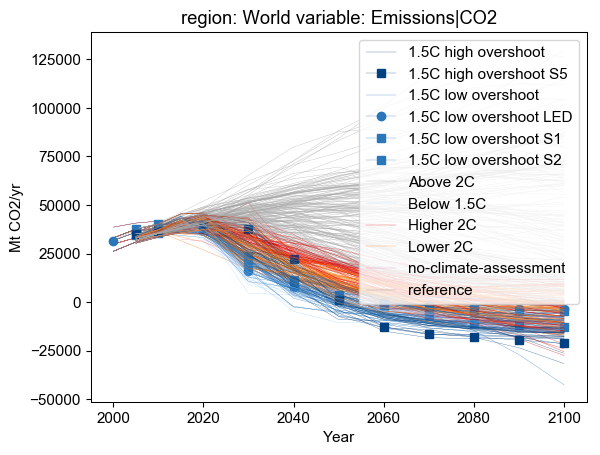

In [61]:
df.filter(exclude=False, variable='Emissions|CO2').line_plot(**plotting_args, marker='marker')

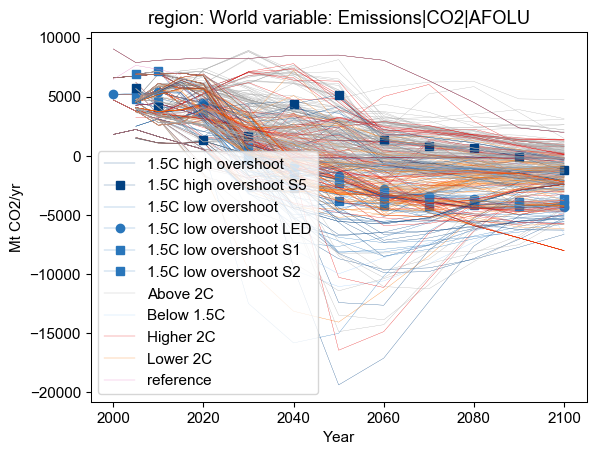

In [62]:
df.filter(exclude=False, variable='Emissions|CO2|AFOLU').line_plot(**plotting_args, marker='marker')

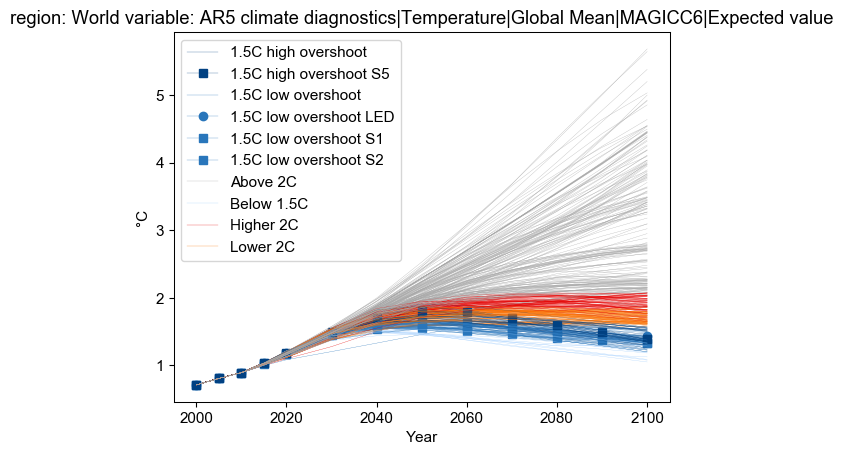

In [63]:
df.filter(exclude=False, variable=expected_warming).line_plot(**plotting_args, marker='marker')

## Import scientific references and publication status
The following block reads in an Excel table with the details of the scientific references for each scenario.

The main cell of this section loops over all entries in this Excel table, filters for the relevant scenarios,
and assigns a short reference and the publication status. If multiple references are relevant for a scenario, the references are compiled, and the 'highest' publication status is written to the metadata.

In [64]:
ref_cols = ['project', 'model', 'scenario', 'reference', 'doi', 'bibliography']

In [65]:
sr1p5.set_meta('undefined', 'reference')
sr1p5.set_meta('unknown', 'project')

In [66]:
refs = pd.read_csv('../bibliography/scenario_references.csv', encoding='iso-8859-1')

_refs = {'index': []}
for i in ref_cols:
    _refs.update({i.title(): []})

In [67]:
for cols in refs.iterrows():
    c = cols[1]
    filters = {}
    
    # check that filters are defined
    if c.model is np.NaN and c.scenario is np.NaN:
        logger.warn('project `{}` on line {} has no filters assigned'
                    .format(c.project, cols[0]))
        continue

    # filter for scenarios to apply the project and publication tags
    filters = {}
    for i in ['model', 'scenario']:
        if c[i] is not np.NaN:
            if ";" in c[i]:
                filters.update({i: re.sub(";", "", c[i]).split()})
            else:
                filters.update({i: c[i]})
    
    df = sr1p5.filter(**filters)
    if df.scenarios().empty:
        logger.warn('no scenarios satisfy filters for project `{}` on line {} ({})'
                    .format(c.project, cols[0], filters))
        continue

    # write to meta-tables dictionary
    _refs['index'].append(cols[0])
    for i in ref_cols:
        _refs[i.title()].append(c[i])

    sr1p5.meta.loc[df.meta.index, 'project'] = c['project']

    for i in df.meta.index:
        r = c['reference']
        sr1p5.meta.loc[i, 'reference'] = r if sr1p5.meta.loc[i, 'reference'] == 'undefined' \
            else '{}; {}'.format(sr1p5.meta.loc[i, 'reference'], r)

In [68]:
cols = [i.title() for i in ref_cols]
meta_tables['references'] = pd.DataFrame(_refs)[cols]
meta_docs['reference'] = 'Scientific references'
meta_docs['project'] = 'Project identifier contributing the scenario'

## Peak warming and indicator of median global warming peak-and-decline

Determine peak warming (relative to pre-industrial temperature) and end-of century warming 
and add this to the scenario metadata.
Then, compute the "peak-and-decline" indicator as the difference between peak warming and warming in 2100.

In [69]:
def peak_warming(x, return_year=False):
    peak = x[x == x.max()]
    if return_year:
        return peak.index[0]
    else:
        return float(max(peak))

In [70]:
median_temperature = sr1p5.filter(variable=median_warming).timeseries()

In [71]:
name = 'median warming at peak (MAGICC6)'
sr1p5.set_meta(median_temperature.apply(peak_warming, raw=False, axis=1), name)
meta_docs[name] = 'median warming above pre-industrial temperature at peak (°C) as computed by MAGICC6'

In [72]:
name = 'year of peak warming (MAGICC6)'
sr1p5.set_meta(median_temperature.apply(peak_warming, return_year=True, raw=False, axis=1), name)
meta_docs[name] = 'year of peak median warming as computed by MAGICC6'

In [73]:
name = 'median warming in 2100 (MAGICC6)'
sr1p5.set_meta(median_temperature[2100], name)
meta_docs[name] = 'median warming above at peak above pre-industrial temperature as computed by MAGICC6'

In [74]:
name = 'median warming peak-and-decline (MAGICC6)'
peak_decline = sr1p5['median warming at peak (MAGICC6)'] - sr1p5['median warming in 2100 (MAGICC6)']
sr1p5.set_meta(peak_decline, name)
meta_docs[name] = 'median warming peak-and-decline from peak to temperature in 2100 (°C) as computed by MAGICC6'

### Add mean temperature at peak from 'FAIR' model diagnostics

In [75]:
median_temperature_fair = sr1p5.filter(variable='AR5 climate diagnostics|Temperature|Global Mean|FAIR|MED')\
    .timeseries()

In [76]:
name = 'median warming at peak (FAIR)'
sr1p5.set_meta(median_temperature_fair.apply(peak_warming, raw=False, axis=1), name)
meta_docs[name] = 'median warming above pre-industrial temperature at peak (°C) as computed by FAIR'

In [77]:
name = 'year of peak warming (FAIR)'
sr1p5.set_meta(median_temperature_fair.apply(peak_warming, return_year=True, raw=False, axis=1), name)
meta_docs[name] = 'year of peak median warming as computed by FAIR'

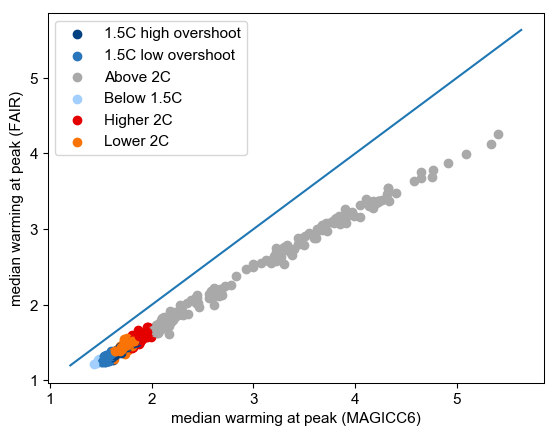

In [78]:
fig, ax = plt.subplots()
sr1p5.filter(category=cats).scatter(ax=ax,
                                    x='median warming at peak (MAGICC6)',
                                    y='median warming at peak (FAIR)', color='category')
ax.plot(ax.get_xlim(), ax.get_xlim())

In [79]:
import matplotlib
matplotlib.__version__

'3.0.2'

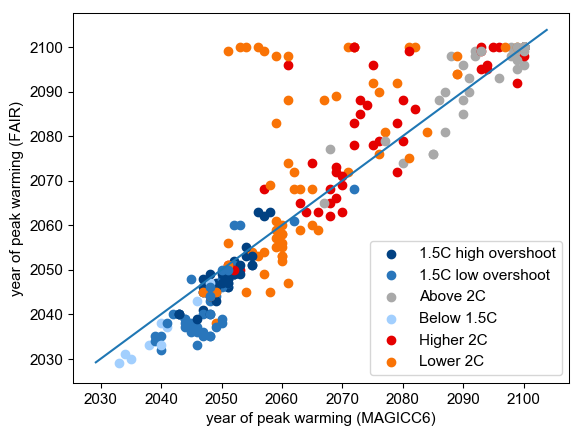

In [80]:
fig, ax = plt.subplots()
sr1p5.scatter(ax=ax, x='year of peak warming (MAGICC6)', y='year of peak warming (FAIR)', color='category')
ax.plot(ax.get_xlim(), ax.get_xlim())

## Computation of threshold exceedance year and 'overshoot' year count

Determine the year when a scenario exceeds a specific temperature threshold, 
and for how many years the threshold is exceeded.  

This section uses the function ``exceedance()`` to determine the exceedance and return years.
The function ``overshoot_severity()`` computes the cumulative exceedance of the 1.5°C threshold
(i.e., the sum of temperature-years above the threshold).

In [81]:
def exceedance(temperature, years, threshold):
    exceedance_yr = None
    return_yr = None
    overshoot_yr_count = None
    prev_temp = 0
    prev_yr = None

    for yr, curr_temp in zip(years, temperature):
        if np.isnan(curr_temp):
            continue
        
        if exceedance_yr is None and curr_temp > threshold:
            x = (curr_temp - prev_temp) / (yr - prev_yr) # temperature change per year
            exceedance_yr = prev_yr + int((threshold - prev_temp) / x) + 1 # add one because int() rounds down
        if exceedance_yr is not None and return_yr is None and curr_temp < threshold:
            x = (prev_temp - curr_temp) / (yr - prev_yr) # temperature change per year
            return_yr = prev_yr + int((prev_temp - threshold) / x) + 1
        prev_temp = curr_temp
        prev_yr = yr

    if return_yr is not None and exceedance_yr is not None:
        overshoot_yr_count = int(return_yr - exceedance_yr)
    if exceedance_yr is not None:
        exceedance_yr = int(exceedance_yr)
    if return_yr is not None:
        return_yr = int(return_yr)

    return [exceedance_yr, return_yr, overshoot_yr_count]

In [83]:
exceedance_meta = median_temperature.apply(exceedance, axis=1, raw=False,
                                           years=median_temperature.columns, threshold=1.5)

In [84]:
name = 'exceedance year|1.5°C'
sr1p5.set_meta(exceedance_meta.apply(lambda x: x[0]), name)
meta_docs[name] = 'year in which the 1.5°C median warming threshold is exceeded'

name = 'return year|1.5°C'
sr1p5.set_meta(exceedance_meta.apply(lambda x: x[1]), name)
meta_docs[name] = 'year in which median warming returns below the 1.5°C threshold'

name = 'overshoot years|1.5°C'
sr1p5.set_meta(exceedance_meta.apply(lambda x: x[2]), name)
meta_docs[name] = 'number of years where 1.5°C median warming threshold is exceeded'

In [85]:
def overshoot_severity(x, meta):
    exceedance_yr = meta.loc[x.name[0:2]]['exceedance year|1.5°C']
    return_yr = meta.loc[x.name[0:2]]['return year|1.5°C'] - 1 
    # do not include year in which mean temperature returns to below 1.5
    if exceedance_yr > 0 and return_yr > 0:
        return pyam.cumulative(x, exceedance_yr, return_yr) - (return_yr - exceedance_yr + 1) * 1.5

In [86]:
name = 'exceedance severity|1.5°C'
sr1p5.set_meta(median_temperature.apply(overshoot_severity, axis=1, raw=False, meta=sr1p5.meta), name)
meta_docs[name] = 'sum of median temperature exceeding the 1.5°C threshold'

In [88]:
exceedance_meta = median_temperature.apply(exceedance, axis=1, raw=False,
                                           years=median_temperature.columns, threshold=2)

In [89]:
name = 'exceedance year|2.0°C'
sr1p5.set_meta(exceedance_meta.apply(lambda x: x[0]), name)
meta_docs[name] = 'year in which the 2.0°C median warming threshold is exceeded'

name = 'return year|2.0°C'
sr1p5.set_meta(exceedance_meta.apply(lambda x: x[1]), name)
meta_docs[name] = 'year in which median warming returns below the 2.0°C threshold'

name = 'overshoot years|2.0°C'
sr1p5.set_meta(exceedance_meta.apply(lambda x: x[2]), name)
meta_docs[name] = 'number of years where 2.0°C median warming threshold is exceeded'

## Secondary categorization and meta-data assignment according to CO2 emissions

### Defining the range for cumulative indicators and units

All cumulative indicators are computed over the time horizon 2016-2100 (including the year 2100 in every summation).

In [90]:
baseyear = 2016
lastyear = 2100

In [91]:
def filter_and_convert(variable):
    return (sr1p5
            .filter(variable=variable)
            .convert_unit('Mt CO2/yr', 'Gt CO2/yr')
            .timeseries()
           )

unit = 'Gt CO2/yr'
cumulative_unit = 'Gt CO2'

In [92]:
co2 = filter_and_convert('Emissions|CO2')

In [93]:
name = 'minimum net CO2 emissions ({})'.format(unit)
sr1p5.set_meta(co2.apply(np.nanmin, axis=1), name)
meta_docs[name] = 'Minimum of net CO2 emissions over the century ({})'.format(unit)

### Indicators from cumulative CO2 emissions over the entire century (2016-2100)

Compute the total cumulative CO2 emissions for secondary categorization of scenarios.
Cumulative CO2 emissions are a first-order proxy for global mean temperature change.
Emissions are interpolated linearly between years. The `last_year` value is included in the summation.

The function `pyam.cumulative()` defined below aggregates timeseries values from `first_year` until `last_year`,
including both first and last year in the total. The function assumes linear interpolation for years where no values are provided.

In [94]:
name = 'cumulative CO2 emissions ({}-{}, {})'.format(baseyear, lastyear, cumulative_unit)
sr1p5.set_meta(co2.apply(pyam.cumulative, raw=False, axis=1, first_year=baseyear, last_year=lastyear), name)
meta_docs[name] = 'Cumulative net CO2 emissions from {} until {} (including the last year, {})'.format(
    baseyear, lastyear, cumulative_unit)

In [95]:
ccs = filter_and_convert('Carbon Sequestration|CCS')

In [96]:
cum_ccs_label = 'cumulative CCS ({}-{}, {})'.format(baseyear, lastyear, cumulative_unit)
sr1p5.set_meta(ccs.apply(pyam.cumulative, raw=False, axis=1, first_year=baseyear, last_year=lastyear), cum_ccs_label)
meta_docs[cum_ccs_label] = 'Cumulative carbon capture and sequestration from {} until {} (including the last year, {})'\
    .format(baseyear, lastyear, cumulative_unit)

In [97]:
beccs = filter_and_convert('Carbon Sequestration|CCS|Biomass')

In [98]:
cum_beccs_label = 'cumulative BECCS ({}-{}, {})'.format(baseyear, lastyear, cumulative_unit)
sr1p5.set_meta(beccs.apply(pyam.cumulative, raw=False, axis=1, first_year=baseyear, last_year=lastyear), cum_beccs_label)
meta_docs[cum_beccs_label] = 'Cumulative carbon capture and sequestration from bioenergy from {} until {} (including the last year, {})'.format(
    baseyear, lastyear, cumulative_unit)

Issue [#9](https://github.com/iiasa/ipcc_sr15_scenario_analysis/issues/9) requested to add the data for scenario where timeseries data for bioenergy with CCS was not provided explicitly (and hence not captured by the computation above) but could implicitly by assessed from the CCS timeseries data.

In [99]:
filled_ccs = sr1p5.meta[sr1p5.meta[cum_ccs_label] == 0][cum_beccs_label]

In [100]:
sr1p5.set_meta(name=cum_beccs_label, meta=0, index=filled_ccs[filled_ccs.isna()].index)

In [101]:
seq_lu = filter_and_convert('Carbon Sequestration|Land Use')

In [102]:
name = 'cumulative sequestration land-use ({}-{}, {})'.format(baseyear, lastyear, cumulative_unit)
sr1p5.set_meta(seq_lu.apply(pyam.cumulative, raw=False, axis=1, first_year=baseyear, last_year=lastyear), name)
meta_docs[name] = 'Cumulative carbon sequestration from land use from {} until {} (including the last year, {})'.format(
    baseyear, lastyear, cumulative_unit)

### Cumulative CO2 emissions until peak warming

In [103]:
def get_from_meta_column(df, x, col):
    val = df.meta.loc[x.name[0:2], col]
    return val if val < np.inf else max(x.index)

In [104]:
name = 'cumulative CO2 emissions ({} to peak warming, {})'.format(baseyear, cumulative_unit)
sr1p5.set_meta(co2.apply(lambda x: pyam.cumulative(x, first_year=baseyear,
                                                   last_year=get_from_meta_column(sr1p5, x,
                                                                                  'year of peak warming (MAGICC6)')),
                         raw=False, axis=1), name)
meta_docs[name] = 'cumulative net CO2 emissions from {} until the year of peak warming as computed by MAGICC6 (including the year of peak warming, {})'.format(
    baseyear, cumulative_unit)

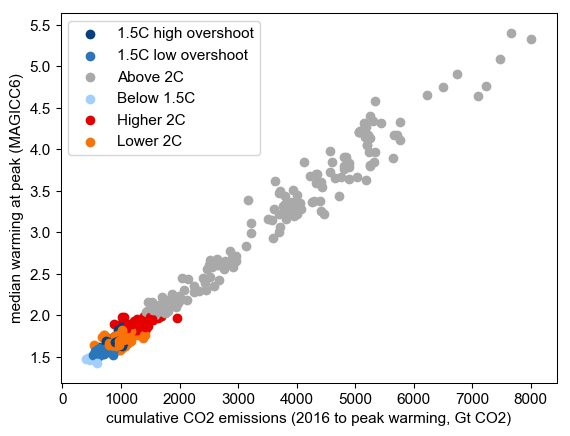

In [105]:
(
    sr1p5
    .filter(category=cats)
    .scatter(x='cumulative CO2 emissions (2016 to peak warming, {})'.format(cumulative_unit),
             y='median warming at peak (MAGICC6)', color='category')
)

### Cumulative CO2 emissions until net-zero of total emissions

In [106]:
def year_of_net_zero(data, years, threshold):
    prev_val = 0
    prev_yr = np.nan

    for yr, val in zip(years, data):
        if np.isnan(val):
            continue
        
        if val < threshold:
            x = (val - prev_val) / (yr - prev_yr) # absolute change per year
            return prev_yr + int((threshold - prev_val) / x) + 1 # add one because int() rounds down
        
        prev_val = val
        prev_yr = yr
    return np.inf

In [107]:
name = 'year of netzero CO2 emissions'
sr1p5.set_meta(co2.apply(year_of_net_zero, years=co2.columns, threshold=0, axis=1), name)
meta_docs[name] = 'year in which net CO2 emissions reach zero'

In [108]:
name = 'cumulative CO2 emissions ({} to netzero, {})'.format(baseyear, cumulative_unit)
sr1p5.set_meta(co2.apply(lambda x: pyam.cumulative(x, first_year=baseyear,
                                                   last_year=get_from_meta_column(sr1p5, x,
                                                                                  'year of netzero CO2 emissions')),
                         raw=False, axis=1), name)
meta_docs[name] = 'net CO2 emissions from {} until the year of peak warming (including the last year, {})'.format(
    baseyear, cumulative_unit)

In [109]:
name = 'warming at netzero (MAGICC6)'
sr1p5.set_meta(median_temperature.apply(lambda x: x[get_from_meta_column(sr1p5, x,
                                                                         'year of netzero CO2 emissions')],
                                        raw=False, axis=1), name)
meta_docs[name] = 'median warming above pre-industrial temperatures in the year of net-zero CO2 emission (MAGICC, °C)'.format(
    baseyear, cumulative_unit)

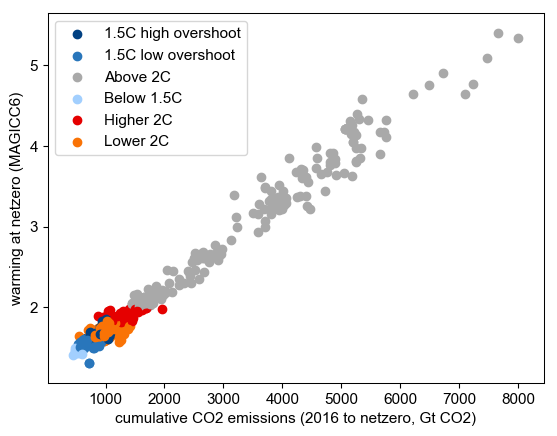

In [110]:
(
    sr1p5
    .scatter(x='cumulative CO2 emissions (2016 to netzero, {})'.format(cumulative_unit),
             y='warming at netzero (MAGICC6)', color='category')
)

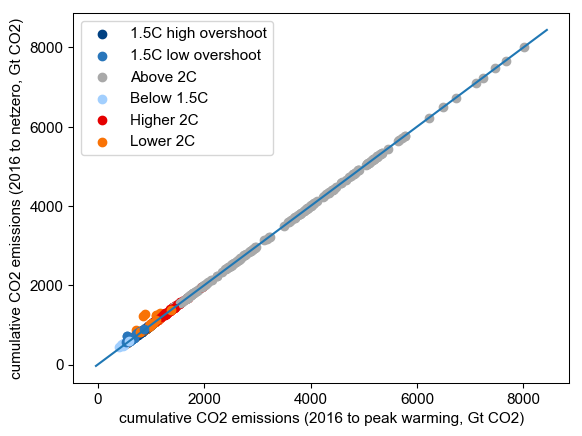

In [111]:
fig, ax = plt.subplots()
(
    sr1p5
    .scatter(ax=ax, x='cumulative CO2 emissions (2016 to peak warming, {})'.format(cumulative_unit),
             y='cumulative CO2 emissions (2016 to netzero, {})'.format(cumulative_unit),
             color='category')
)
ax.plot(ax.get_xlim(), ax.get_xlim())

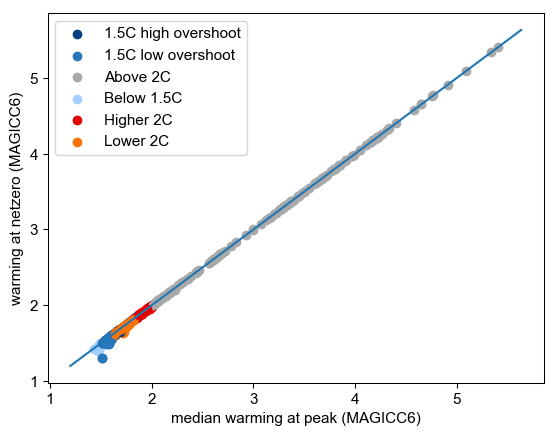

In [112]:
fig, ax = plt.subplots()
(
    sr1p5
    .scatter(ax=ax, x='median warming at peak (MAGICC6)',
             y='warming at netzero (MAGICC6)', color='category')
)
x = np.linspace(*ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim())

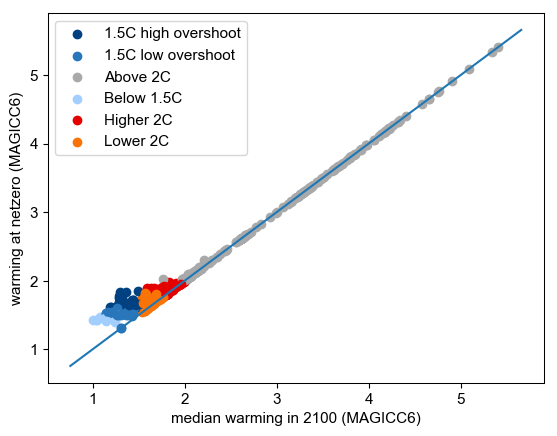

In [113]:
fig, ax = plt.subplots()
(
    sr1p5
    .scatter(ax=ax, x='median warming in 2100 (MAGICC6)',
             y='warming at netzero (MAGICC6)', color='category')
)
x = np.linspace(*ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim())

## Categorization and meta-data assignment according to final energy demand

Add a categorization column to the metadata categorization based on final energy demand at the end of the century.

In [114]:
horizon = list(range(2000, 2020, 5)) + list(range(2020, 2101, 10))
df = sr1p5.filter(year=horizon)

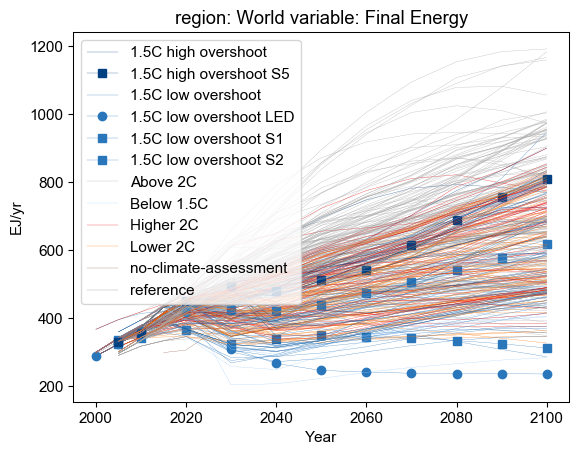

In [115]:
fe_df = df.filter(variable='Final Energy')
fe_df.line_plot(**plotting_args, marker='marker')

In [116]:
fe = fe_df.timeseries()

In [117]:
name = 'final energy|2100'
sr1p5.set_meta(fe[2100], name)
meta_docs[name] = 'Final energy demand at the end of the century (EJ/yr)'

## Indicators on carbon price development

Retrieve the carbon price timeseries and derive the following indicators:
 - carbon price in 2030, 2050, and 2100 given both in 2010$ as reported by models and as NPV
 - simple average of NPV (2030-2100)
 - annual compounded NPV (2030-2100)
 - continuously compounded NPV (2030-2100)

All net present values (NPV) are given relative to the year 2020.
They are calculated assuming a 5% discount rate.

In [118]:
dct = {'Indicator type': 
           ['Price by year',
            'Price by year (as NPV)',
            'Average (Avg) NPV',
            'Annual compounded (AC) NPV)',
            'Continuously compounded (CC) NPV',
            '', 'Note on NPV'
           ],
       'Description':
           ['Global carbon price as reported by each scenario',
            'Global carbon price as reported by each scenario discounted to 2020 NPV',
            'Cumulative NPV carbon price from 2030 until 2100 divided by number of years (71)',
            'Annual compounded NPV carbon price from 2030 until 2100 divided by number of years (71)',
            'Continuously compounded NPV carbon price from 2030 until 2100 divided by number of years (71)',
            '', 'All NPV indicators are discounted to 2020 using a 5% discount rate'
           ]
      }
meta_tables['carbon_price'] = pd.DataFrame(dct)[['Indicator type', 'Description']]

In [119]:
carbonprice_df = sr1p5.filter(variable='Price|Carbon', year=range(2020, 2101, 10))

### Plot the carbon price trajectories by category

There are some outlier scenarios with very high carbon prices, so the following cell manually sets the limits of the y-axis.

/Users/aa/.pyenv_intel/versions/anaconda3-2018.12/envs/iam-original/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/aa/.pyenv_intel/versions/anaconda3-2018.12/envs/iam-original/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 10000)

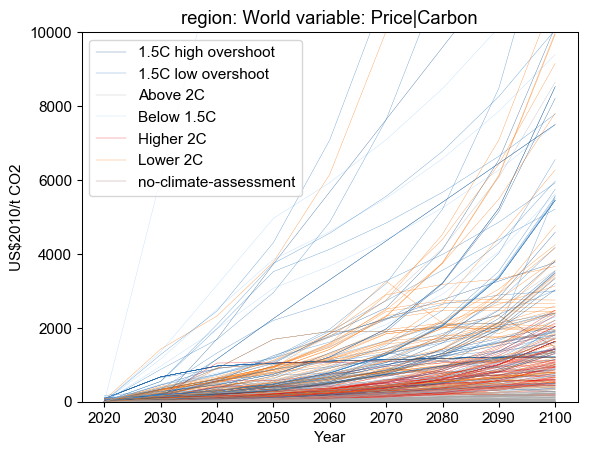

In [120]:
fig, ax = plt.subplots()
carbonprice_df.filter(year=range(2020, 2101, 10)).line_plot(ax=ax, **plotting_args)
plt.ylim(ymax=10000, ymin=0)

### Show outliers for verification and assessment

In [121]:
carbon_price = carbonprice_df.timeseries()

In [122]:
carbon_price[carbon_price.apply(lambda x: max([i for i in x if not np.isnan(i)]) > 10000, axis=1)]

2020  \
model                 scenario                              region variable     unit                       
MESSAGE V.3           GEA_Mix_1p5C_AdvNCO2_PartialDelay2020 World  Price|Carbon US$2010/t CO2  46.660823   
POLES ADVANCE         ADVANCE_2030_1.5C-2100                World  Price|Carbon US$2010/t CO2   2.712291   
POLES EMF33           EMF33_1.5C_limbio                     World  Price|Carbon US$2010/t CO2   0.704306   
                      EMF33_1.5C_nofuel                     World  Price|Carbon US$2010/t CO2   0.720055   
                      EMF33_WB2C_none                       World  Price|Carbon US$2010/t CO2   0.719918   
REMIND 1.7            CEMICS-1.5-CDR8                       World  Price|Carbon US$2010/t CO2   1.803400   
REMIND-MAgPIE 1.5     SSP2-19                               World  Price|Carbon US$2010/t CO2   8.066300   
REMIND-MAgPIE 1.7-3.0 EMF33_WB2C_none                       World  Price|Carbon US$2010/t CO2   9.032320   
WITCH-GLOBIOM 3.1     SSP1-19                               World  Price|Carbon US$2010/t CO2   7.059897   
                      SSP4-19                               World  Price|Carbon US$2010/t CO2   7.261031   

                                                                                                      2030  \
model                 scenario                              region variable     unit                         
MESSAGE V.3           GEA_Mix_1p5C_AdvNCO2_PartialDelay2020 World  Price|Carbon US$2010/t CO2  1423.867874   
POLES ADVANCE         ADVANCE_2030_1.5C-2100                World  Price|Carbon US$2010/t CO2    37.651289   
POLES EMF33           EMF33_1.5C_limbio                     World  Price|Carbon US$2010/t CO2  6050.000000   
                      EMF33_1.5C_nofuel                     World  Price|Carbon US$2010/t CO2  1353.000000   
                      EMF33_WB2C_none                       World  Price|Carbon US$2010/t CO2   550.000000   
REMIND 1.7            CEMICS-1.5-CDR8                       World  Price|Carbon US$2010/t CO2   454.275100   
REMIND-MAgPIE 1.5     SSP2-19                               World  Price|Carbon US$2010/t CO2   196.130000   
REMIND-MAgPIE 1.7-3.0 EMF33_WB2C_none                       World  Price|Carbon US$2010/t CO2   415.934200   
WITCH-GLOBIOM 3.1     SSP1-19                               World  Price|Carbon US$2010/t CO2  1275.235264   
                      SSP4-19                               World  Price|Carbon US$2010/t CO2   874.829674   

                                                                                                       2040  \
model                 scenario                              region variable     unit                          
MESSAGE V.3           GEA_Mix_1p5C_AdvNCO2_PartialDelay2020 World  Price|Carbon US$2010/t CO2   2319.330739   
POLES ADVANCE         ADVANCE_2030_1.5C-2100                World  Price|Carbon US$2010/t CO2   1699.580566   
POLES EMF33           EMF33_1.5C_limbio                     World  Price|Carbon US$2010/t CO2  12100.000000   
                      EMF33_1.5C_nofuel                     World  Price|Carbon US$2010/t CO2   3157.000269   
                      EMF33_WB2C_none                       World  Price|Carbon US$2010/t CO2   2090.000000   
REMIND 1.7            CEMICS-1.5-CDR8                       World  Price|Carbon US$2010/t CO2    739.966300   
REMIND-MAgPIE 1.5     SSP2-19                               World  Price|Carbon US$2010/t CO2    636.240000   
REMIND-MAgPIE 1.7-3.0 EMF33_WB2C_none                       World  Price|Carbon US$2010/t CO2    676.534210   
WITCH-GLOBIOM 3.1     SSP1-19                               World  Price|Carbon US$2010/t CO2   2454.961901   
                      SSP4-19                               World  Price|Carbon US$2010/t CO2   1684.139060   

                                                                                                       2050  \
model                 scenario        

### Compute net-present values of the carbon price

In [123]:
carbon_price_npv = carbon_price.copy()

r = 0.05
discount_year = 2020
npv_first_year = 2030
npv_last_year = 2100

for y in carbon_price_npv.columns: 
    carbon_price_npv[y] = carbon_price_npv[y] / math.pow(1 + r, y - discount_year)

In [124]:
discount_docstring = ' from {} until {} including the last year, '.format(npv_first_year, npv_last_year) + \
    'discounted to {} using a {}% discount rate'.format(discount_year, r)

In [125]:
for y in [2030, 2050, 2100]:
    name = 'carbon price|{}'.format(y)
    sr1p5.set_meta(carbon_price[y], 'carbon price|{}'.format(y))
    meta_docs[name] = 'carbon price in {} (2010USD/tCO2)'.format(y)
    
    name = 'carbon price|{} (NPV)'.format(y)
    sr1p5.set_meta(carbon_price_npv[y], name)
    meta_docs[name] = 'net-present value of carbon price in {} (2010USD/tCO2), discounted to {}'.format(
        y, discount_year)

In [126]:
name = 'carbon price|Avg NPV (2030-2100)'
sr1p5.set_meta(carbon_price_npv.apply(pyam.cumulative, first_year=2030, last_year=2100,
                                      raw=False, axis=1)/71, name)
meta_docs[name] = 'continuously compounded net-present value of carbon prices (2010USD/tCO2)' + discount_docstring

In [127]:
def compute_w1_annual(r, dt):
    value = 0
    for i in range(1, dt):  # range does not include the last element, but this is 0 in this formula
        value += math.pow(1 / (1 + r), i) * (1 - i / dt)
    return value

def compute_w2_annual(r, dt):
    value = 0
    for i in range(1, dt + 1): # range does not include the last element
        value += math.pow(1 / (1 + r), i - dt) * (i / dt)
    return value

w1_annual = {}
w2_annual = {}

In [128]:
def compute_w1_compounded(r, dt):
    return 1 / r - (1 - math.exp(-r * dt)) / (r * r * dt)

def compute_w2_compounded(r, dt):
    return - 1 / r + (math.exp(r * dt) - 1) / (r * r * dt)

w1_compounded = {}
w2_compounded = {}

In [129]:
# this function is an adaptation of 'pyam.timeseries:cumulative()'

def npv_weighted(x, first_year, last_year, w1, w2, w1_function, w2_function, r):    
    if min(x.index) > first_year or max(x.index) < last_year:
        return np.nan

    x[first_year] = pyam.fill_series(x, first_year)
    x[last_year] = pyam.fill_series(x, last_year)

    years = [i for i in x.index if i >= first_year and i <= last_year
             and ~np.isnan(x[i])]
    years.sort()

    # loop over years
    if not np.isnan(x[first_year]) and not np.isnan(x[last_year]):
        value = 0
        for (i, yr) in enumerate(years[:-1]):
            next_yr = years[i+1]
            dt = next_yr - yr
            if dt not in w1.keys():
                w1[dt] = w1_function(r, dt)
            if dt not in w2.keys():
                w2[dt] = w2_function(r, dt)               
            # the summation is shifted to include the first year fully in sum,
            # otherwise, would return a weighted average of `yr` and `next_yr`
            value += w1[dt] * x[yr] + w2[dt] * x[next_yr]

        # the loop above does not include the last element in range `last_year`,
        # therefore added explicitly
        value += x[last_year]

        return value / (last_year - first_year + 1)

In [130]:
name = 'carbon price|AC NPV (2030-2100)'
sr1p5.set_meta(carbon_price_npv.apply(npv_weighted, first_year=npv_first_year, last_year=npv_last_year,
                                      w1=w1_annual, w2=w2_annual, 
                                      w1_function=compute_w1_annual, w2_function=compute_w2_annual, r=r,
                                      raw=False, axis=1), name)
meta_docs[name] = 'anually compounded net-present value of carbon prices (2010USD/tCO2)' + discount_docstring

In [131]:
name = 'carbon price|CC NPV (2030-2100)'
sr1p5.set_meta(carbon_price_npv.apply(npv_weighted, first_year=npv_first_year, last_year=npv_last_year, 
                                      w1=w1_compounded, w2=w2_compounded, 
                                      w1_function=compute_w1_compounded, w2_function=compute_w2_compounded, r=r,
                                      raw=False, axis=1), name)
meta_docs[name] = 'continuously compounded net-present value of carbon prices (2010USD/tCO2)' + discount_docstring

## View categorization and indicators, export metadata and grouping specifications

The metadata (categorization and diagnostic indicators) is exported as an `xlsx` spreadsheet to be used by other scripts for subsequent analysis and visualization. The specifications of groupings and markers are exported as a `yaml` file to be imported by other notebooks.

In [132]:
[i for i in sr1p5.meta.columns if i not in meta_docs.keys()]

['exclude']

In [133]:
sr1p5.meta.head()

exclude            category  \
model       scenario                                              
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100    False  1.5C low overshoot   
            ADVANCE_2020_Med2C        False           Higher 2C   
            ADVANCE_2020_WB2C         False            Lower 2C   
            ADVANCE_2030_Med2C        False            Above 2C   
            ADVANCE_2030_Price1.5C    False            Lower 2C   

                                                 subcategory  \
model       scenario                                           
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100  Lower 1.5C low overshoot   
            ADVANCE_2020_Med2C                     Higher 2C   
            ADVANCE_2020_WB2C                       Lower 2C   
            ADVANCE_2030_Med2C                      Above 2C   
            ADVANCE_2030_Price1.5C                  Lower 2C   

                                   Kyoto-GHG|2010 (SAR) baseline marker  \
model       scenario                                                      
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100             in range      NaN          
            ADVANCE_2020_Med2C                 in range      NaN          
            ADVANCE_2020_WB2C                  in range      NaN          
            ADVANCE_2030_Med2C                 in range      NaN          
            ADVANCE_2030_Price1.5C             in range      NaN          

                                                                      reference  \
model       scenario                                                              
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100  Luderer et al., 2018; Vrontisi et al., 2018   
            ADVANCE_2020_Med2C      Luderer et al., 2018; Vrontisi et al., 2018   
            ADVANCE_2020_WB2C       Luderer et al., 2018; Vrontisi et al., 2018   
            ADVANCE_2030_Med2C      Luderer et al., 2018; Vrontisi et al., 2018   
            ADVANCE_2030_Price1.5C  Luderer et al., 2018; Vrontisi et al., 2018   

                                    project  median warming at peak (MAGICC6)  \
model       scenario                                                            
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100  ADVANCE                          1.537766   
            ADVANCE_2020_Med2C      ADVANCE                          1.965214   
            ADVANCE_2020_WB2C       ADVANCE                          1.607855   
            ADVANCE_2030_Med2C      ADVANCE                          2.139910   
            ADVANCE_2030_Price1.5C  ADVANCE                          1.742394   

                                    year of peak warming (MAGICC6)  ...  \
model       scenario                                                ...   
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100                          2047.0  ...   
            ADVANCE_2020_Med2C                              2100.0  ...   
            ADVANCE_2020_WB2C                               2057.0  ...   
            ADVANCE_2030_Med2C                              2100.0  ...   
            ADVANCE_2030_Price1.5C                          2049.0  ...   

                                    final energy|2100  carbon price|2030  \
model       scenario                                                       
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100           524.0021          297.63833   
            ADVANCE_2020_Med2C               589.9357          218.41490   
            ADVANCE_2020_WB2C                526.0832          219.34682   
            ADVANCE_2030_Med2C               576.9094           67.54726   
            ADVANCE_2030_Price1.5C           510.2482           78.64703   

                                    carbon price|2030 (NPV)  \
model       scenario                                          
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100               182.724116   
            ADVANCE_2020_Med2C                   134.087802   
            ADVANCE_2020_WB2C                    134.659920   
            ADVANCE_2030_Med2C                    41.468158   
    

In [134]:
_meta_docs = pd.DataFrame(meta_docs, index=[0]).T.reset_index()
_meta_docs.rename(columns={'index': 'Category or indicator', 0: 'Description'}, inplace=True)

In [135]:
writer = pd.ExcelWriter('sr15_metadata_indicators.xlsx')
pyam.utils.write_sheet(writer, 'meta', sr1p5.meta, index=True)
pyam.utils.write_sheet(writer, 'categories_indicators_doc', _meta_docs, index=False)
for name, df in meta_tables.items():
    pyam.utils.write_sheet(writer, 'def_{}'.format(name), df)
writer.save()

In [136]:
specs['run_control'] = rc.store

In [137]:
with io.open('sr15_specs.yaml', 'w', encoding='utf8') as outfile:
    yaml.dump(specs, outfile, default_flow_style=False, allow_unicode=True)